### Configure GPU usage

In [1]:
import tensorflow as tf

In [9]:
tf.__version__

'2.3.0'

In [2]:
tf.__version__

'2.3.0'

In [3]:
gpus = tf.config.list_physical_devices('GPU')[2:4]

In [11]:
gpus

[PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [4]:
gpus

[]

In [12]:
tf.config.set_visible_devices(gpus, 'GPU')

In [13]:
tf.config.list_logical_devices('CPU') 

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

In [5]:
tf.config.list_logical_devices('CPU') 

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

In [14]:
tf.config.list_logical_devices('GPU') 

[LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU')]

In [6]:
tf.config.list_logical_devices('GPU') 

[]

### Run experiments

In [7]:
from model_experiments.vae_experiment import VaeExperiment
from general.experiment import GenerativeModelType, TransformerType, OptimizerType
from general.utils import OutputActivation
from evaluators.machine_learning_evaluator import MachineLearningEvaluator, EvaluatorModelType, MetricType, ScalerType
from models.utils import Activation

import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from copy import deepcopy
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [47]:
# Adult
# early stop epsilon value = 2.5
# record gradients subset = ["race", "relationship"]

# UCI Credit Card
# early stop epsilon value = 2.5 
# record gradients subset = ["SEX", "EDUCATION"]

# Bank Marketing
# early stop epsilon value = 2.25
# record gradients subset = ["job"]

In [8]:
base_config = {
    "model_type": GenerativeModelType.VAE,
    "name": "vae_experiment_bn_test_dp",
    "data_path": "data/",
    "data_processing": {},
    "model_config": {
        "compress_dims": [128, 128],
        "decompress_dims": [128, 128],
        "compress_activations": [Activation.LeakyReLU, Activation.LeakyReLU],
        "decompress_activations": [Activation.LeakyReLU, Activation.LeakyReLU],
        "latent_dim": 128,
        "output_activations": {
            "continuous": OutputActivation.TANH,
            "categorical": OutputActivation.SOFTMAX,
        },
    },
    "model_train": {
        "test_pct": 0.3,
        "k_fold": True,
        "stratified_by_col": None,
        "epochs": 500,
        "batch_size": 64,
        "dp_optimizer_type": OptimizerType.GradientDescentOptimizer,
        "record_gradients": {"enabled": True, "subset": []},
        "transformer": {
            "type": TransformerType.BGM,
            "kwargs": {"outlier_clipping": True, "n_clusters": 6},
        },
        "early_stop": {"enabled": False},
        "early_stop_epsilon": {"enabled": True},
    },
    "diff_priv": {
        "enabled": True,
        "microbatches": 1,
        "l2_norm_clip": 5.0,
        "noise_multiplier": 0.8,    
    },
}

In [9]:
base_config_no_dp = {
    "model_type": GenerativeModelType.VAE,
    "name": "vae_experiment_bn_test_no_dp",
    "data_path": "data/",
    "data_processing": {},
    "model_config": {
        "compress_dims": [128, 128],
        "decompress_dims": [128, 128],
        "compress_activations": [Activation.LeakyReLU, Activation.LeakyReLU],
        "decompress_activations": [Activation.LeakyReLU, Activation.LeakyReLU],
        "latent_dim": 128,
        "output_activations": {
            "continuous": OutputActivation.TANH,
            "categorical": OutputActivation.SOFTMAX,
        },
    },
    "model_train": {
        "test_pct": 0.3,
        "k_fold": True,
        "stratified_by_col": None,
        "epochs": 8,
        "learning_rate": .001,
        "batch_size": 64,
        "record_gradients": {"enabled": True, "subset": []},
        "optimizer_type": OptimizerType.GradientDescentOptimizer,
        "transformer": {
            "type": TransformerType.BGM,
            "kwargs": {"outlier_clipping": True, "n_clusters": 6},
        },
        "early_stop": {"enabled": False},
        "early_stop_epsilon": {"enabled": False},
    },
    "diff_priv": {
        "enabled": False,   
    },
}

In [10]:
adult_config = {
    "model_type": GenerativeModelType.VAE,
    "name": "vae_experiment_mi_attack",
    "dataset": "adult.csv",
    "data_path": "data/",
    "data_processing": {},
    "model_config": {
        "compress_dims": [128, 128],
        "decompress_dims": [128, 128],
        "compress_activations": [Activation.LeakyReLU, Activation.LeakyReLU],
        "decompress_activations": [Activation.LeakyReLU, Activation.LeakyReLU],
        "latent_dim": 128,
        "output_activations": {
            "continuous": OutputActivation.TANH,
            "categorical": OutputActivation.SOFTMAX,
        },
    },
    "model_train": {
        "seed": 10,
        "test_pct": 0.,
        "k_fold": False,
        "stratified_by_col": None,
        "epochs": 500,
        "batch_size": 128,
        "dp_optimizer_type": OptimizerType.DPAdamGaussianOptimizer,
        "record_gradients": {"enabled": False, "subset": []},
        "transformer": {
            "type": TransformerType.BGM,
            "kwargs": {"outlier_clipping": True, "n_clusters": 6},
        },
        "early_stop": {"enabled": False},
        "early_stop_epsilon": {"enabled": True, "value": 2.75},
    },
    "diff_priv": {
        "enabled": True,
        "microbatches": 1,
        "l2_norm_clip": 5.0,
        "noise_multiplier": 0.8,    
    },
}

In [84]:
batch_norm = [True, False]
for with_batch_norm in batch_norm:
    cur_config = deepcopy(adult_config)
    cur_config["model_config"]["batch_norm"] = with_batch_norm  
    cur_experiment = VaeExperiment(cur_config)
    cur_experiment.run(automatic_overwrite=False)    

Training single model
Model number: 0
Max Epsilon of 2.75 reached at Epoch: 12, Step: 0
Start of epoch 0
step 0: mean loss = 32.81
step 100: mean loss = 32.33
step 200: mean loss = 31.43
epsilon = 1.91
Start of epoch 1
step 0: mean loss = 31.21
step 100: mean loss = 30.06
step 200: mean loss = 29.04
epsilon = 2.02
Start of epoch 2
step 0: mean loss = 29.04
step 100: mean loss = 28.29
step 200: mean loss = 27.53
epsilon = 2.12
Start of epoch 3
step 0: mean loss = 27.38
step 100: mean loss = 26.46
step 200: mean loss = 25.87
epsilon = 2.20
Start of epoch 4
step 0: mean loss = 25.54
step 100: mean loss = 24.73
step 200: mean loss = 24.57
epsilon = 2.28
Start of epoch 5
step 0: mean loss = 23.93
step 100: mean loss = 23.55
step 200: mean loss = 23.23
epsilon = 2.35
Start of epoch 6
step 0: mean loss = 22.94
step 100: mean loss = 22.31
step 200: mean loss = 21.46
epsilon = 2.43
Start of epoch 7
step 0: mean loss = 22.02
step 100: mean loss = 21.23
step 200: mean loss = 20.61
epsilon = 2.49


experiment saved to 23264b0782f7b9baf76aa0e2ebc5fa855d4d39b9.pkl
Training single model
Model number: 0
Max Epsilon of 2.75 reached at Epoch: 12, Step: 0
Start of epoch 0
step 0: mean loss = 31.31
step 100: mean loss = 29.91
step 200: mean loss = 29.35
epsilon = 1.91
Start of epoch 1
step 0: mean loss = 28.60
step 100: mean loss = 27.28
step 200: mean loss = 27.45
epsilon = 2.02
Start of epoch 2
step 0: mean loss = 26.64
step 100: mean loss = 25.42
step 200: mean loss = 24.68
epsilon = 2.12
Start of epoch 3
step 0: mean loss = 24.27
step 100: mean loss = 23.36
step 200: mean loss = 22.77
epsilon = 2.20
Start of epoch 4
step 0: mean loss = 22.65
step 100: mean loss = 21.26
step 200: mean loss = 21.28
epsilon = 2.28
Start of epoch 5
step 0: mean loss = 21.43
step 100: mean loss = 20.29
step 200: mean loss = 20.63
epsilon = 2.35
Start of epoch 6
step 0: mean loss = 20.94
step 100: mean loss = 20.17
step 200: mean loss = 20.42
epsilon = 2.43
Start of epoch 7
step 0: mean loss = 20.92
step 1

step 0: mean loss = 19.78
epsilon = 2.75
experiment saved to 404d16aae768b97c18ce5aa3293376a5cc3f6c09.pkl


In [12]:
import time

In [13]:
start = time.time()
batch_norm = [True, False]
for with_batch_norm in batch_norm:
    cur_config = deepcopy(adult_config)
    cur_config["model_config"]["batch_norm"] = with_batch_norm  
    cur_experiment = VaeExperiment(cur_config)
    cur_experiment.run(automatic_overwrite=False)
end = time.time()
print(end - start)    

Training single model
Model number: 0
Max Epsilon of 2.75 reached at Epoch: 12, Step: 0
Start of epoch 0
step 0: mean loss = 32.81
step 100: mean loss = 32.33
step 200: mean loss = 31.43
epsilon = 1.91
Start of epoch 1
step 0: mean loss = 31.21
step 100: mean loss = 30.06
step 200: mean loss = 29.04
epsilon = 2.02
Start of epoch 2
step 0: mean loss = 29.04
step 100: mean loss = 28.29
step 200: mean loss = 27.53
epsilon = 2.12
Start of epoch 3
step 0: mean loss = 27.38
step 100: mean loss = 26.46
step 200: mean loss = 25.87
epsilon = 2.20
Start of epoch 4
step 0: mean loss = 25.54
step 100: mean loss = 24.73
step 200: mean loss = 24.57
epsilon = 2.28
Start of epoch 5
step 0: mean loss = 23.93
step 100: mean loss = 23.55
step 200: mean loss = 23.23
epsilon = 2.35
Start of epoch 6
step 0: mean loss = 22.94
step 100: mean loss = 22.31
step 200: mean loss = 21.46
epsilon = 2.43
Start of epoch 7
step 0: mean loss = 22.02
step 100: mean loss = 21.23
step 200: mean loss = 20.61
epsilon = 2.49


epsilon = 2.75
experiment saved to 23264b0782f7b9baf76aa0e2ebc5fa855d4d39b9.pkl
Training single model
Model number: 0
Max Epsilon of 2.75 reached at Epoch: 12, Step: 0
Start of epoch 0
step 0: mean loss = 31.31
step 100: mean loss = 29.91
step 200: mean loss = 29.35
epsilon = 1.91
Start of epoch 1
step 0: mean loss = 28.60
step 100: mean loss = 27.28
step 200: mean loss = 27.45
epsilon = 2.02
Start of epoch 2
step 0: mean loss = 26.64
step 100: mean loss = 25.42
step 200: mean loss = 24.68
epsilon = 2.12
Start of epoch 3
step 0: mean loss = 24.27
step 100: mean loss = 23.36
step 200: mean loss = 22.77
epsilon = 2.20
Start of epoch 4
step 0: mean loss = 22.65
step 100: mean loss = 21.26
step 200: mean loss = 21.28
epsilon = 2.28
Start of epoch 5
step 0: mean loss = 21.43
step 100: mean loss = 20.29
step 200: mean loss = 20.63
epsilon = 2.35
Start of epoch 6
step 0: mean loss = 20.94
step 100: mean loss = 20.17
step 200: mean loss = 20.42
epsilon = 2.43
Start of epoch 7
step 0: mean loss

experiment saved to 404d16aae768b97c18ce5aa3293376a5cc3f6c09.pkl
653.8233213424683


In [15]:
!/usr/bin/nvidia-smi

/bin/bash: /usr/bin/nvidia-smi: No such file or directory


In [16]:
# datasets = ["adult.csv", "bank_marketing.csv", "uci_credit_card.csv"]
datasets = ["adult.csv", "bank_marketing.csv"]
gradient_record_subsets = {
    "uci_credit_card.csv": ["SEX", "EDUCATION"],
    "bank_marketing.csv": ["job"],
    "adult.csv": ["race", "relationship"]
}
batch_norm = [True, False]
seeds = range(10, 11)
uci_categorical_cols = [
    "SEX",
    "EDUCATION",
    "MARRIAGE",
    "PAY_0",
    "PAY_1",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
    "DEFAULT",
]
bank_marketing_read_csv_kwargs = {"delimiter": ";"}
bank_marketing_epsilon_value = 2.25
other_epsilon_value = 2.5

In [61]:
# train without dp

for seed in [10, 11]:
    for with_batch_norm in batch_norm:
        for dataset in datasets:
            # set config - generic
            cur_config = deepcopy(base_config_no_dp)
            cur_config["model_train"]["seed"] = seed
            cur_config["model_config"]["batch_norm"] = with_batch_norm  
            cur_config["dataset"] = dataset
            if dataset == "uci_credit_card.csv":
                cur_config["data_processing"]["categorical_columns"] = uci_categorical_cols
            if dataset == "bank_marketing.csv":
                cur_config["data_processing"]["read_csv_kwargs"] = bank_marketing_read_csv_kwargs
            cur_config["model_train"]["record_gradients"]["subset"] = gradient_record_subsets[dataset]
            # run experiemnt
            cur_experiment = VaeExperiment(cur_config)
            try:
                cur_experiment.run(automatic_overwrite=False)
            except SystemExit:
                continue

Training model with 3 fold validation
Model number: 0
Start of epoch 0
step 0: mean loss = 32.38
step 100: mean loss = 26.56
step 200: mean loss = 22.32
step 300: mean loss = 19.93
Start of epoch 1
step 0: mean loss = 19.26
step 100: mean loss = 17.21
step 200: mean loss = 15.85
step 300: mean loss = 14.70
Start of epoch 2
step 0: mean loss = 15.21
step 100: mean loss = 13.93
step 200: mean loss = 13.73
Start of epoch 3
step 0: mean loss = 13.06
step 100: mean loss = 12.38
step 200: mean loss = 12.20
step 300: mean loss = 11.37
Start of epoch 4
step 0: mean loss = 12.07
step 100: mean loss = 11.13
step 200: mean loss = 11.29
step 300: mean loss = 10.66
Start of epoch 5
step 0: mean loss = 11.14
step 100: mean loss = 10.21
step 200: mean loss = 10.56
step 300: mean loss = 9.74
Start of epoch 6
step 0: mean loss = 10.62
step 100: mean loss = 9.78
step 200: mean loss = 9.66
step 300: mean loss = 8.94
Start of epoch 7
step 0: mean loss = 9.99
step 100: mean loss = 8.92
step 200: mean loss 

Model number: 1
Start of epoch 0
step 0: mean loss = 31.61
step 100: mean loss = 26.55
step 200: mean loss = 22.70
step 300: mean loss = 19.65
Start of epoch 1
step 0: mean loss = 19.21
step 100: mean loss = 16.83
step 200: mean loss = 16.11
step 300: mean loss = 14.87
Start of epoch 2
step 0: mean loss = 14.92
step 100: mean loss = 13.74
step 200: mean loss = 13.77
step 300: mean loss = 12.87
Start of epoch 3
step 0: mean loss = 12.94
step 100: mean loss = 12.34
step 200: mean loss = 12.37
step 300: mean loss = 11.51
Start of epoch 4
step 0: mean loss = 11.63
step 100: mean loss = 11.54
step 200: mean loss = 11.22
step 300: mean loss = 10.82
Start of epoch 5
step 0: mean loss = 10.82
step 100: mean loss = 10.39
step 200: mean loss = 10.73
step 300: mean loss = 10.03
Start of epoch 6
step 0: mean loss = 9.93
step 100: mean loss = 10.10
step 200: mean loss = 9.65
step 300: mean loss = 9.38
Start of epoch 7
step 0: mean loss = 9.52
step 100: mean loss = 9.61
step 200: mean loss = 9.26
st

Model number: 2
Start of epoch 0
step 0: mean loss = 30.95
step 100: mean loss = 26.16
step 200: mean loss = 21.86
step 300: mean loss = 19.27
Start of epoch 1
step 0: mean loss = 18.55
step 100: mean loss = 16.65
step 200: mean loss = 15.04
step 300: mean loss = 14.27
Start of epoch 2
step 0: mean loss = 14.29
step 100: mean loss = 13.62
step 200: mean loss = 13.22
step 300: mean loss = 12.36
Start of epoch 3
step 0: mean loss = 12.32
step 100: mean loss = 12.09
step 200: mean loss = 11.58
step 300: mean loss = 10.92
Start of epoch 4
step 0: mean loss = 11.45
step 100: mean loss = 10.85
step 200: mean loss = 10.67
step 300: mean loss = 10.35
Start of epoch 5
step 0: mean loss = 10.45
step 100: mean loss = 10.22
step 200: mean loss = 9.82
step 300: mean loss = 9.60
Start of epoch 6
step 0: mean loss = 9.71
step 100: mean loss = 9.31
step 200: mean loss = 9.34
step 300: mean loss = 8.99
Start of epoch 7
step 0: mean loss = 9.08
step 100: mean loss = 9.01
step 200: mean loss = 8.80
step 

experiment saved to eaaa5646eb5d21290c4a24cf78db896fe7fce82c.pkl
Training model with 3 fold validation
Model number: 0
Start of epoch 0
step 0: mean loss = 37.55
step 100: mean loss = 30.65
step 200: mean loss = 26.04
step 300: mean loss = 23.38
step 400: mean loss = 20.76
Start of epoch 1
step 0: mean loss = 20.46
step 100: mean loss = 17.87
step 200: mean loss = 18.12
step 300: mean loss = 17.83
step 400: mean loss = 16.52
Start of epoch 2
step 0: mean loss = 17.03
step 100: mean loss = 14.51
step 200: mean loss = 15.60
step 300: mean loss = 15.44
step 400: mean loss = 14.85
Start of epoch 3
step 0: mean loss = 15.00
step 100: mean loss = 12.80
step 200: mean loss = 13.83
step 300: mean loss = 14.11
step 400: mean loss = 13.11
Start of epoch 4
step 0: mean loss = 13.89
step 100: mean loss = 11.61
step 200: mean loss = 12.49
step 300: mean loss = 12.85
step 400: mean loss = 12.16
Start of epoch 5
step 0: mean loss = 12.87
step 100: mean loss = 10.54
step 200: mean loss = 11.72
step 30

Model number: 1
Start of epoch 0
step 0: mean loss = 38.54
step 100: mean loss = 31.61
step 200: mean loss = 27.95
step 300: mean loss = 23.68
step 400: mean loss = 21.18
Start of epoch 1
step 0: mean loss = 21.05
step 100: mean loss = 18.83
step 200: mean loss = 19.49
step 300: mean loss = 18.13
step 400: mean loss = 16.76
Start of epoch 2
step 0: mean loss = 16.92
step 100: mean loss = 15.45
step 200: mean loss = 16.49
step 300: mean loss = 15.76
step 400: mean loss = 14.45
Start of epoch 3
step 0: mean loss = 14.79
step 100: mean loss = 13.60
step 200: mean loss = 14.63
step 300: mean loss = 14.27
step 400: mean loss = 12.99
Start of epoch 4
step 0: mean loss = 13.37
step 100: mean loss = 12.10
step 200: mean loss = 13.11
step 300: mean loss = 12.98
step 400: mean loss = 12.08
Start of epoch 5
step 0: mean loss = 12.12
step 100: mean loss = 11.31
step 200: mean loss = 12.05
step 300: mean loss = 11.72
step 400: mean loss = 11.12
Start of epoch 6
step 0: mean loss = 11.29
step 100: m

Model number: 2
Start of epoch 0
step 0: mean loss = 39.75
step 100: mean loss = 32.01
step 200: mean loss = 27.74
step 300: mean loss = 24.11
step 400: mean loss = 21.38
Start of epoch 1
step 0: mean loss = 21.09
step 100: mean loss = 18.79
step 200: mean loss = 18.82
step 300: mean loss = 17.91
step 400: mean loss = 16.58
Start of epoch 2
step 0: mean loss = 16.30
step 100: mean loss = 15.18
step 200: mean loss = 16.16
step 300: mean loss = 15.53
step 400: mean loss = 14.42
Start of epoch 3
step 0: mean loss = 14.16
step 100: mean loss = 13.60
step 200: mean loss = 14.38
step 300: mean loss = 13.89
step 400: mean loss = 12.95
Start of epoch 4
step 0: mean loss = 12.85
step 100: mean loss = 12.32
step 200: mean loss = 13.12
step 300: mean loss = 12.62
step 400: mean loss = 11.64
Start of epoch 5
step 0: mean loss = 11.87
step 100: mean loss = 11.10
step 200: mean loss = 11.96
step 300: mean loss = 11.70
step 400: mean loss = 10.49
Start of epoch 6
step 0: mean loss = 11.17
step 100: m

experiment saved to e1cb5aabf8403df62c11fb93aad1656391fdb02a.pkl
Training model with 3 fold validation
Model number: 0
Start of epoch 0
step 0: mean loss = 30.69
step 100: mean loss = 23.51
step 200: mean loss = 19.60
step 300: mean loss = 19.06
Start of epoch 1
step 0: mean loss = 19.40
step 100: mean loss = 18.83
step 200: mean loss = 18.38
step 300: mean loss = 17.91
Start of epoch 2
step 0: mean loss = 18.84
step 100: mean loss = 17.99
step 200: mean loss = 18.16
step 300: mean loss = 17.22
Start of epoch 3
step 0: mean loss = 17.82
step 100: mean loss = 17.11
step 200: mean loss = 17.06
step 300: mean loss = 16.19
Start of epoch 4
step 0: mean loss = 16.46
step 100: mean loss = 16.08
step 200: mean loss = 16.12
step 300: mean loss = 15.55
Start of epoch 5
step 0: mean loss = 15.61
step 100: mean loss = 15.11
step 200: mean loss = 15.49
step 300: mean loss = 14.83
Start of epoch 6
step 0: mean loss = 15.16
step 100: mean loss = 14.62
step 200: mean loss = 14.81
step 300: mean loss 

Model number: 1
Start of epoch 0
step 0: mean loss = 30.89
step 100: mean loss = 25.10
step 200: mean loss = 20.68
step 300: mean loss = 19.06
Start of epoch 1
step 0: mean loss = 19.73
step 100: mean loss = 18.89
step 200: mean loss = 18.62
step 300: mean loss = 17.93
Start of epoch 2
step 0: mean loss = 18.85
step 100: mean loss = 17.91
step 200: mean loss = 17.89
step 300: mean loss = 17.23
Start of epoch 3
step 0: mean loss = 17.92
step 100: mean loss = 17.05
step 200: mean loss = 16.96
step 300: mean loss = 16.20
Start of epoch 4
step 0: mean loss = 16.46
step 100: mean loss = 16.20
step 200: mean loss = 16.17
step 300: mean loss = 15.43
Start of epoch 5
step 0: mean loss = 15.89
step 100: mean loss = 15.43
step 200: mean loss = 15.71
step 300: mean loss = 14.83
Start of epoch 6
step 0: mean loss = 15.01
step 100: mean loss = 14.67
step 200: mean loss = 14.66
step 300: mean loss = 13.90
Start of epoch 7
step 0: mean loss = 14.19
step 100: mean loss = 13.95
step 200: mean loss = 14

Model number: 2
Start of epoch 0
step 0: mean loss = 28.93
step 100: mean loss = 22.63
step 200: mean loss = 19.48
step 300: mean loss = 18.88
Start of epoch 1
step 0: mean loss = 19.58
step 100: mean loss = 18.89
step 200: mean loss = 17.97
step 300: mean loss = 18.00
Start of epoch 2
step 0: mean loss = 18.66
step 100: mean loss = 18.07
step 200: mean loss = 17.93
step 300: mean loss = 17.22
Start of epoch 3
step 0: mean loss = 17.52
step 100: mean loss = 17.05
step 200: mean loss = 16.55
step 300: mean loss = 15.82
Start of epoch 4
step 0: mean loss = 16.32
step 100: mean loss = 15.88
step 200: mean loss = 15.70
step 300: mean loss = 15.24
Start of epoch 5
step 0: mean loss = 15.80
step 100: mean loss = 15.74
step 200: mean loss = 14.99
step 300: mean loss = 14.45
Start of epoch 6
step 0: mean loss = 14.90
step 100: mean loss = 14.43
step 200: mean loss = 14.53
step 300: mean loss = 13.95
Start of epoch 7
step 0: mean loss = 14.35
step 100: mean loss = 13.99
step 200: mean loss = 13

experiment saved to 3a9d0ba908953680cd62ccfa3dab7e6d06e62977.pkl
Training model with 3 fold validation
Model number: 0
Start of epoch 0
step 0: mean loss = 34.47
step 100: mean loss = 28.47
step 200: mean loss = 26.57
step 300: mean loss = 25.62
step 400: mean loss = 25.02
Start of epoch 1
step 0: mean loss = 24.66
step 100: mean loss = 22.64
step 200: mean loss = 23.50
step 300: mean loss = 23.20
step 400: mean loss = 21.27
Start of epoch 2
step 0: mean loss = 21.27
step 100: mean loss = 18.65
step 200: mean loss = 19.48
step 300: mean loss = 19.54
step 400: mean loss = 18.58
Start of epoch 3
step 0: mean loss = 18.56
step 100: mean loss = 16.34
step 200: mean loss = 17.67
step 300: mean loss = 17.96
step 400: mean loss = 17.11
Start of epoch 4
step 0: mean loss = 17.41
step 100: mean loss = 15.20
step 200: mean loss = 16.02
step 300: mean loss = 16.56
step 400: mean loss = 15.93
Start of epoch 5
step 0: mean loss = 16.21
step 100: mean loss = 13.73
step 200: mean loss = 14.94
step 30

Model number: 1
Start of epoch 0
step 0: mean loss = 36.89
step 100: mean loss = 29.10
step 200: mean loss = 27.95
step 300: mean loss = 25.91
step 400: mean loss = 24.60
Start of epoch 1
step 0: mean loss = 25.04
step 100: mean loss = 23.33
step 200: mean loss = 24.59
step 300: mean loss = 22.56
step 400: mean loss = 21.07
Start of epoch 2
step 0: mean loss = 20.88
step 100: mean loss = 18.84
step 200: mean loss = 20.27
step 300: mean loss = 18.92
step 400: mean loss = 18.58
Start of epoch 3
step 0: mean loss = 18.08
step 100: mean loss = 16.85
step 200: mean loss = 18.26
step 300: mean loss = 17.56
step 400: mean loss = 16.89
Start of epoch 4
step 0: mean loss = 16.83
step 100: mean loss = 15.70
step 200: mean loss = 16.74
step 300: mean loss = 16.34
step 400: mean loss = 15.72
Start of epoch 5
step 0: mean loss = 15.35
step 100: mean loss = 14.24
step 200: mean loss = 15.07
step 300: mean loss = 14.74
step 400: mean loss = 14.65
Start of epoch 6
step 0: mean loss = 14.27
step 100: m

Model number: 2
Start of epoch 0
step 0: mean loss = 36.74
step 100: mean loss = 29.71
step 200: mean loss = 27.75
step 300: mean loss = 26.32
step 400: mean loss = 24.70
Start of epoch 1
step 0: mean loss = 25.10
step 100: mean loss = 23.73
step 200: mean loss = 24.26
step 300: mean loss = 23.92
step 400: mean loss = 22.22
Start of epoch 2
step 0: mean loss = 22.31
step 100: mean loss = 20.41
step 200: mean loss = 21.56
step 300: mean loss = 21.24
step 400: mean loss = 19.18
Start of epoch 3
step 0: mean loss = 19.29
step 100: mean loss = 17.88
step 200: mean loss = 18.71
step 300: mean loss = 18.63
step 400: mean loss = 17.28
Start of epoch 4
step 0: mean loss = 17.22
step 100: mean loss = 16.46
step 200: mean loss = 17.20
step 300: mean loss = 16.90
step 400: mean loss = 15.93
Start of epoch 5
step 0: mean loss = 15.58
step 100: mean loss = 14.92
step 200: mean loss = 15.66
step 300: mean loss = 15.68
step 400: mean loss = 14.55
Start of epoch 6
step 0: mean loss = 14.59
step 100: m

experiment saved to 846ee02cdb12772ef5d23ccda79e5026ac56b9b8.pkl
Training model with 3 fold validation
Model number: 0
Start of epoch 0
step 0: mean loss = 31.28
step 100: mean loss = 25.92
step 200: mean loss = 21.53
step 300: mean loss = 19.80
Start of epoch 1
step 0: mean loss = 18.51
step 100: mean loss = 16.53
step 200: mean loss = 14.45
step 300: mean loss = 15.25
Start of epoch 2
step 0: mean loss = 14.21
step 100: mean loss = 13.12
step 200: mean loss = 11.98
step 300: mean loss = 13.44
Start of epoch 3
step 0: mean loss = 12.18
step 100: mean loss = 11.60
step 200: mean loss = 10.77
step 300: mean loss = 12.23
Start of epoch 4
step 0: mean loss = 10.97
step 100: mean loss = 10.58
step 200: mean loss = 9.59
step 300: mean loss = 11.26
Start of epoch 5
step 0: mean loss = 10.03
step 100: mean loss = 9.65
step 200: mean loss = 9.11
step 300: mean loss = 10.44
Start of epoch 6
step 0: mean loss = 9.66
step 100: mean loss = 9.13
step 200: mean loss = 8.52
step 300: mean loss = 10.1

Model number: 1
Start of epoch 0
step 0: mean loss = 30.88
step 100: mean loss = 25.78
step 200: mean loss = 21.60
step 300: mean loss = 20.26
Start of epoch 1
step 0: mean loss = 17.99
step 100: mean loss = 16.89
step 200: mean loss = 15.16
step 300: mean loss = 16.01
Start of epoch 2
step 0: mean loss = 13.77
step 100: mean loss = 13.59
step 200: mean loss = 12.56
step 300: mean loss = 14.19
Start of epoch 3
step 0: mean loss = 12.11
step 100: mean loss = 12.22
step 200: mean loss = 11.14
step 300: mean loss = 13.25
Start of epoch 4
step 0: mean loss = 11.00
step 100: mean loss = 11.17
step 200: mean loss = 10.65
step 300: mean loss = 12.48
Start of epoch 5
step 0: mean loss = 10.24
step 100: mean loss = 10.62
step 200: mean loss = 9.78
step 300: mean loss = 11.56
Start of epoch 6
step 0: mean loss = 9.59
step 100: mean loss = 10.09
step 200: mean loss = 9.03
step 300: mean loss = 10.85
Start of epoch 7
step 0: mean loss = 8.98
step 100: mean loss = 9.53
step 200: mean loss = 8.77
st

Model number: 2
Start of epoch 0
step 0: mean loss = 31.63
step 100: mean loss = 25.93
step 200: mean loss = 22.73
step 300: mean loss = 19.14
Start of epoch 1
step 0: mean loss = 18.17
step 100: mean loss = 16.31
step 200: mean loss = 15.66
step 300: mean loss = 14.36
Start of epoch 2
step 0: mean loss = 13.63
step 100: mean loss = 13.06
step 200: mean loss = 13.53
step 300: mean loss = 12.26
Start of epoch 3
step 0: mean loss = 11.82
step 100: mean loss = 11.76
step 200: mean loss = 12.24
step 300: mean loss = 11.36
Start of epoch 4
step 0: mean loss = 10.51
step 100: mean loss = 10.63
step 200: mean loss = 11.17
step 300: mean loss = 10.44
Start of epoch 5
step 0: mean loss = 9.83
step 100: mean loss = 10.09
step 200: mean loss = 10.42
step 300: mean loss = 9.88
Start of epoch 6
step 0: mean loss = 9.18
step 100: mean loss = 9.13
step 200: mean loss = 9.74
step 300: mean loss = 9.11
Start of epoch 7
step 0: mean loss = 8.82
step 100: mean loss = 8.62
step 200: mean loss = 9.13
step 

experiment saved to 68ae89e1bce7f0c9bb41eb24aa5ff0c6543762ee.pkl
Training model with 3 fold validation
Model number: 0
Start of epoch 0
step 0: mean loss = 38.98
step 100: mean loss = 31.24
step 200: mean loss = 26.83
step 300: mean loss = 23.53
step 400: mean loss = 21.18
Start of epoch 1
step 0: mean loss = 21.17
step 100: mean loss = 19.06
step 200: mean loss = 17.71
step 300: mean loss = 17.09
step 400: mean loss = 16.71
Start of epoch 2
step 0: mean loss = 16.65
step 100: mean loss = 15.60
step 200: mean loss = 14.85
step 300: mean loss = 14.79
step 400: mean loss = 14.68
Start of epoch 3
step 0: mean loss = 14.72
step 100: mean loss = 13.68
step 200: mean loss = 13.19
step 300: mean loss = 13.46
step 400: mean loss = 12.80
Start of epoch 4
step 0: mean loss = 13.20
step 100: mean loss = 12.41
step 200: mean loss = 12.14
step 300: mean loss = 12.14
step 400: mean loss = 11.96
Start of epoch 5
step 0: mean loss = 12.30
step 100: mean loss = 11.42
step 200: mean loss = 11.18
step 30

Model number: 1
Start of epoch 0
step 0: mean loss = 38.34
step 100: mean loss = 32.05
step 200: mean loss = 27.39
step 300: mean loss = 24.23
step 400: mean loss = 22.07
Start of epoch 1
step 0: mean loss = 21.79
step 100: mean loss = 19.40
step 200: mean loss = 17.75
step 300: mean loss = 17.64
step 400: mean loss = 16.92
Start of epoch 2
step 0: mean loss = 16.89
step 100: mean loss = 15.62
step 200: mean loss = 14.95
step 300: mean loss = 15.17
step 400: mean loss = 14.37
Start of epoch 3
step 0: mean loss = 14.80
step 100: mean loss = 13.75
step 200: mean loss = 13.33
step 300: mean loss = 13.81
step 400: mean loss = 12.99
Start of epoch 4
step 0: mean loss = 13.44
step 100: mean loss = 12.41
step 200: mean loss = 12.07
step 300: mean loss = 12.66
step 400: mean loss = 12.02
Start of epoch 5
step 0: mean loss = 12.36
step 100: mean loss = 11.54
step 200: mean loss = 11.20
step 300: mean loss = 11.50
step 400: mean loss = 10.97
Start of epoch 6
step 0: mean loss = 11.42
step 100: m

Model number: 2
Start of epoch 0
step 0: mean loss = 39.22
step 100: mean loss = 31.42
step 200: mean loss = 26.57
step 300: mean loss = 23.97
step 400: mean loss = 21.75
Start of epoch 1
step 0: mean loss = 21.03
step 100: mean loss = 18.94
step 200: mean loss = 17.43
step 300: mean loss = 17.54
step 400: mean loss = 16.85
Start of epoch 2
step 0: mean loss = 16.42
step 100: mean loss = 15.52
step 200: mean loss = 14.59
step 300: mean loss = 15.04
step 400: mean loss = 14.41
Start of epoch 3
step 0: mean loss = 14.48
step 100: mean loss = 13.60
step 200: mean loss = 12.75
step 300: mean loss = 13.38
step 400: mean loss = 12.94
Start of epoch 4
step 0: mean loss = 12.97
step 100: mean loss = 12.09
step 200: mean loss = 11.74
step 300: mean loss = 12.14
step 400: mean loss = 11.76
Start of epoch 5
step 0: mean loss = 11.74
step 100: mean loss = 11.06
step 200: mean loss = 10.43
step 300: mean loss = 11.38
step 400: mean loss = 11.14
Start of epoch 6
step 0: mean loss = 11.14
step 100: m

experiment saved to 0485422fbe449f91324d47f515a1e5e7eb63a856.pkl
Training model with 3 fold validation
Model number: 0
Start of epoch 0
step 0: mean loss = 28.72
step 100: mean loss = 23.28
step 200: mean loss = 19.50
step 300: mean loss = 20.38
Start of epoch 1
step 0: mean loss = 19.13
step 100: mean loss = 18.80
step 200: mean loss = 17.71
step 300: mean loss = 19.53
Start of epoch 2
step 0: mean loss = 18.29
step 100: mean loss = 17.84
step 200: mean loss = 17.24
step 300: mean loss = 19.10
Start of epoch 3
step 0: mean loss = 17.32
step 100: mean loss = 17.00
step 200: mean loss = 16.51
step 300: mean loss = 17.76
Start of epoch 4
step 0: mean loss = 16.22
step 100: mean loss = 15.94
step 200: mean loss = 15.20
step 300: mean loss = 16.79
Start of epoch 5
step 0: mean loss = 15.08
step 100: mean loss = 15.08
step 200: mean loss = 14.49
step 300: mean loss = 15.90
Start of epoch 6
step 0: mean loss = 14.47
step 100: mean loss = 14.43
step 200: mean loss = 13.66
step 300: mean loss 

Model number: 1
Start of epoch 0
step 0: mean loss = 28.64
step 100: mean loss = 21.78
step 200: mean loss = 19.04
step 300: mean loss = 20.83
Start of epoch 1
step 0: mean loss = 18.37
step 100: mean loss = 18.78
step 200: mean loss = 18.32
step 300: mean loss = 20.01
Start of epoch 2
step 0: mean loss = 17.88
step 100: mean loss = 17.73
step 200: mean loss = 17.11
step 300: mean loss = 19.06
Start of epoch 3
step 0: mean loss = 16.79
step 100: mean loss = 16.71
step 200: mean loss = 16.28
step 300: mean loss = 18.08
Start of epoch 4
step 0: mean loss = 15.33
step 100: mean loss = 15.35
step 200: mean loss = 15.20
step 300: mean loss = 17.20
Start of epoch 5
step 0: mean loss = 14.32
step 100: mean loss = 14.77
step 200: mean loss = 14.01
step 300: mean loss = 16.06
Start of epoch 6
step 0: mean loss = 13.73
step 100: mean loss = 14.10
step 200: mean loss = 13.38
step 300: mean loss = 15.41
Start of epoch 7
step 0: mean loss = 13.13
step 100: mean loss = 13.62
step 200: mean loss = 12

Model number: 2
Start of epoch 0
step 0: mean loss = 30.22
step 100: mean loss = 23.14
step 200: mean loss = 20.08
step 300: mean loss = 18.55
Start of epoch 1
step 0: mean loss = 18.39
step 100: mean loss = 18.21
step 200: mean loss = 18.56
step 300: mean loss = 17.84
Start of epoch 2
step 0: mean loss = 17.57
step 100: mean loss = 17.23
step 200: mean loss = 18.19
step 300: mean loss = 17.02
Start of epoch 3
step 0: mean loss = 16.88
step 100: mean loss = 16.78
step 200: mean loss = 17.27
step 300: mean loss = 16.28
Start of epoch 4
step 0: mean loss = 15.31
step 100: mean loss = 15.56
step 200: mean loss = 16.05
step 300: mean loss = 14.96
Start of epoch 5
step 0: mean loss = 14.32
step 100: mean loss = 14.78
step 200: mean loss = 15.29
step 300: mean loss = 14.62
Start of epoch 6
step 0: mean loss = 13.54
step 100: mean loss = 13.84
step 200: mean loss = 14.69
step 300: mean loss = 13.46
Start of epoch 7
step 0: mean loss = 12.92
step 100: mean loss = 13.08
step 200: mean loss = 13

experiment saved to 7535fd29f3bf77b599cedbec79c55e9f0d5bf25d.pkl
Training model with 3 fold validation
Model number: 0
Start of epoch 0
step 0: mean loss = 35.95
step 100: mean loss = 29.49
step 200: mean loss = 27.54
step 300: mean loss = 26.25
step 400: mean loss = 25.74
Start of epoch 1
step 0: mean loss = 25.55
step 100: mean loss = 24.06
step 200: mean loss = 23.32
step 300: mean loss = 23.04
step 400: mean loss = 22.93
Start of epoch 2
step 0: mean loss = 22.32
step 100: mean loss = 20.72
step 200: mean loss = 19.73
step 300: mean loss = 19.17
step 400: mean loss = 18.84
Start of epoch 3
step 0: mean loss = 19.29
step 100: mean loss = 18.08
step 200: mean loss = 17.54
step 300: mean loss = 17.11
step 400: mean loss = 17.05
Start of epoch 4
step 0: mean loss = 17.11
step 100: mean loss = 16.08
step 200: mean loss = 15.71
step 300: mean loss = 15.74
step 400: mean loss = 15.64
Start of epoch 5
step 0: mean loss = 15.53
step 100: mean loss = 14.56
step 200: mean loss = 14.07
step 30

Model number: 1
Start of epoch 0
step 0: mean loss = 36.65
step 100: mean loss = 29.87
step 200: mean loss = 26.88
step 300: mean loss = 25.86
step 400: mean loss = 25.45
Start of epoch 1
step 0: mean loss = 25.98
step 100: mean loss = 24.33
step 200: mean loss = 23.50
step 300: mean loss = 23.11
step 400: mean loss = 22.65
Start of epoch 2
step 0: mean loss = 22.54
step 100: mean loss = 20.55
step 200: mean loss = 19.22
step 300: mean loss = 19.18
step 400: mean loss = 18.50
Start of epoch 3
step 0: mean loss = 18.89
step 100: mean loss = 17.59
step 200: mean loss = 17.03
step 300: mean loss = 17.36
step 400: mean loss = 16.98
Start of epoch 4
step 0: mean loss = 16.80
step 100: mean loss = 16.04
step 200: mean loss = 15.77
step 300: mean loss = 15.81
step 400: mean loss = 15.29
Start of epoch 5
step 0: mean loss = 15.37
step 100: mean loss = 14.37
step 200: mean loss = 14.10
step 300: mean loss = 14.33
step 400: mean loss = 13.76
Start of epoch 6
step 0: mean loss = 14.09
step 100: m

Model number: 2
Start of epoch 0
step 0: mean loss = 37.06
step 100: mean loss = 29.63
step 200: mean loss = 26.46
step 300: mean loss = 26.35
step 400: mean loss = 25.48
Start of epoch 1
step 0: mean loss = 25.18
step 100: mean loss = 23.46
step 200: mean loss = 22.43
step 300: mean loss = 22.78
step 400: mean loss = 21.69
Start of epoch 2
step 0: mean loss = 20.76
step 100: mean loss = 19.39
step 200: mean loss = 18.29
step 300: mean loss = 19.24
step 400: mean loss = 18.36
Start of epoch 3
step 0: mean loss = 18.11
step 100: mean loss = 16.98
step 200: mean loss = 16.36
step 300: mean loss = 17.29
step 400: mean loss = 16.66
Start of epoch 4
step 0: mean loss = 16.49
step 100: mean loss = 15.24
step 200: mean loss = 14.98
step 300: mean loss = 15.70
step 400: mean loss = 14.83
Start of epoch 5
step 0: mean loss = 14.64
step 100: mean loss = 14.07
step 200: mean loss = 13.49
step 300: mean loss = 14.36
step 400: mean loss = 13.59
Start of epoch 6
step 0: mean loss = 13.54
step 100: m

experiment saved to 2c196b3bcf2e7a9651f5b8dd82e73665b30b214f.pkl


In [17]:
test_config = {"name": "vae_experiment_bn_test_no_dp"}
existing_configs = MachineLearningEvaluator.existing_configs("data/", test_config=test_config)

In [24]:
eval_input = {'target_col': 'output', 'data_path': 'data/', 'config_file': '404d16aae768b97c18ce5aa3293376a5cc3f6c09.pkl'}
evaluator = MachineLearningEvaluator(**eval_input)

In [25]:
x = evaluator.get_experiment_data()

In [26]:
x["model_runs"][0]["gradient_norms"]

{}

In [27]:
test_config = {"name": "vae_experiment_bn_test_dp"}
existing_configs = MachineLearningEvaluator.existing_configs("data/", test_config=test_config)

In [28]:
eval_input = {'target_col': 'output', 'data_path': 'data/', 'config_file': '13e18f019180e253ee4b1cf10dbe953c762eb185.pkl'}
evaluator = MachineLearningEvaluator(**eval_input)

In [29]:
x = evaluator.get_experiment_data()

No file exists with this config -- exiting process


SystemExit: 

In [30]:
x["model_runs"][0]["gradient_norms"]

{}

In [31]:
# train with dp

for seed in [10, 11]:
    for with_batch_norm in batch_norm:
        for dataset in datasets:
            # set config - generic
            cur_config = deepcopy(base_config)
            cur_config["model_train"]["seed"] = seed
            cur_config["model_train"]["dp_optimizer_type"] = dp_opt
            cur_config["model_config"]["batch_norm"] = with_batch_norm            
            cur_config["dataset"] = dataset
            if dataset == "uci_credit_card.csv":
                cur_config["data_processing"]["categorical_columns"] = uci_categorical_cols
            cur_config["model_train"]["record_gradients"]["subset"] = gradient_record_subsets[dataset]
            # set config - dp
            if dataset == "bank_marketing.csv":
                value = bank_marketing_epsilon_value
                cur_config["data_processing"]["read_csv_kwargs"] = bank_marketing_read_csv_kwargs
            else:
                value = other_epsilon_value
            cur_config["model_train"]["early_stop_epsilon"]["value"] = value
            # run experiemnt
            cur_experiment = VaeExperiment(cur_config)
            try:
                cur_experiment.run(automatic_overwrite=False)
            except SystemExit:
                continue

NameError: name 'dp_opt' is not defined

In [ ]:
for seed in seeds[:5]:
    for with_batch_norm in batch_norm:
        for dataset in datasets:
            # set config
            cur_config = deepcopy(base_config_no_dp)
            cur_config["model_train"]["seed"] = seed
            cur_config["model_config"]["batch_norm"] = with_batch_norm            
            cur_config["dataset"] = dataset
            if dataset == "uci_credit_card.csv":
                cur_config["data_processing"]["categorical_columns"] = uci_categorical_cols
            cur_config["model_train"]["record_gradients"]["subset"] = gradient_record_subsets[dataset]
            # run experiemnt
            cur_experiment = VaeExperiment(cur_config)
            cur_experiment.run(automatic_overwrite=True)

In [10]:
config = {
    "dataset": "uci_credit_card.csv",
    "model_type": GenerativeModelType.VAE,
    "name": "vae_experiment",
    "data_path": "data/",
    "data_processing": {
        "columns_to_drop": ["ID"],
        "columns_rename_map": {"default.payment.next.month": "default"},
        "categorical_columns": [
            "SEX",
            "EDUCATION",
            "MARRIAGE",
            "PAY_0",
            "PAY_1",
            "PAY_2",
            "PAY_3",
            "PAY_4",
            "PAY_5",
            "PAY_6",
            "default",
        ],
    },
    "model_config": {
        "compress_dims": [128, 128],
        "decompress_dims": [128, 128],
        "compress_activations": [Activation.ReLU, Activation.ReLU],
        "decompress_activations": [Activation.ReLU, Activation.ReLU],
        "latent_dim": 128,
        "output_activations": {
            "continuous": OutputActivation.TANH,
            "categorical": OutputActivation.SOFTMAX,
        },
    },
    "model_train": {
        "seed": 1,
        "test_pct": 0.3,
        "k_fold": False,
        "stratified_by_col": None,
        "epochs": 50,
        "dp_optimizer_type": OptimizerType.DPAdamGaussianOptimizer,
    },
    "transformer": {
        "type": TransformerType.BGM,
        "kwargs": {"outlier_clipping": True, "n_clusters": 6},
    },
    "diff_priv": {
        "enabled": True,
        "microbatches": 8,
        "l2_norm_clip": 5.0,
        "noise_multiplier": 0.8,
    },
#     "early_stop_epsilon": {"enabled": True, "value": 2.1},
}

In [149]:
config = {
    "dataset": "adult.csv",
    "model_type": GenerativeModelType.VAE,
    "name": "vae_experiment_classes",
    "data_path": "data/",
    "model_config": {
        "compress_dims": [128, 128],
        "decompress_dims": [128, 128],
        "compress_activations": None,
        "decompress_activations": None,
        "latent_dim": 128,
        "batch_norm": None,
        "output_activations": {
            "continuous": OutputActivation.TANH,
            "categorical": OutputActivation.SOFTMAX,
        },
    },
    "model_train": {
        "seed": None,
        "test_pct": 0.3,
        "k_fold": True,
        "epochs": 50,
        "dp_optimizer_type": OptimizerType.DPAdamGaussianOptimizer,
        "batch_size": 64
    },
    "transformer": {
        "type": TransformerType.BGM,
        "kwargs": {"outlier_clipping": True, "n_clusters": 6},
    },
    "diff_priv": {
        "enabled": True,
        "microbatches": 8,
        "l2_norm_clip": 5.0,
        "noise_multiplier": 0.8
    },
}

In [150]:
all_compress_acts = [[Activation.LeakyReLU, Activation.LeakyReLU], [Activation.ELU, Activation.ELU]]
all_decompress_acts = [[Activation.LeakyReLU, Activation.LeakyReLU], [Activation.ELU, Activation.ELU]]

In [151]:
for seed in range(10):
    config["model_train"]["seed"] = seed
    for compress_acts, decompress_acts in list(zip(all_compress_acts, all_decompress_acts)):
        config["model_config"]["compress_activations"] = compress_acts
        config["model_config"]["decompress_activations"] = decompress_acts
        for batch_norm in [True, False]:
            config["model_config"]["batch_norm"] = batch_norm  
            vae_experiment = VaeExperiment(config)
            vae_experiment.run()


Training model with 3 fold validation
Model number: 0


KeyboardInterrupt: 

### Evaluations

In [13]:
test_config_bn = {
    'dataset': 'adult.csv',
    'diff_priv': {"l2_norm_clip": 5, "enabled": True},
    'model_train': {"dp_optimizer_type": 2},
    'transformer': {'kwargs': {'n_clusters': 6}, 'type': 1},
    "model_config": {"batch_norm": True}
}

In [14]:
test_config = {
    'dataset': 'adult.csv',
    'diff_priv': {"l2_norm_clip": 5, "enabled": True},
    'model_train': {'stratified_by_col': None, "dp_optimizer_type": 2},
    'transformer': {'kwargs': {'n_clusters': 6}, 'type': 1}
}
test_config["name"] = 'vae_experiment_noise08'

In [15]:
def plot_data_utility_scores(
    target_col,
    data_path,
    configs,
    model,y
    metrics,
    include_real=False,
    scaler_type=None,
    scaler_kwargs=None,
    model_kwargs=None,
    metric_kwargs=None,
    holdout=None,
    subset=None,
):
    all_group_scores = {}
    for group_name, group_configs in configs.items():
        group_scores = []
        for config_hash, config in group_configs.items():
            eval_input = {'target_col': target_col, 'data_path': data_path,
                          'config_file': config_hash}
            evaluator = MachineLearningEvaluator(**eval_input)
            scores = evaluator.data_utility_scores(
                model=model,
                metrics=metrics,
                scaler_type=scaler_type,
                scaler_kwargs=scaler_kwargs,
                model_kwargs=model_kwargs,
                metric_kwargs=metric_kwargs,
                holdout=holdout,
                subset=subset,
                include_train=False
            )
            group_scores.append(scores)
        all_group_scores[group_name] = pd.concat(group_scores, axis=0)
    columns = list(scores.columns)
    cols_to_plot = [col for col in columns if "fake" in col]
    img_per_row = 3
    rows = int(np.ceil(len(cols_to_plot) / img_per_row))
    fig, axes = plt.subplots(rows, img_per_row, figsize=(20, rows*5))
    if axes.ndim == 1:
        axes = np.expand_dims(axes, 0)
    fig.subplots_adjust(hspace=0.35, wspace=0.2)
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            col_idx = i * img_per_row + j
            if col_idx < len(cols_to_plot):
                col_name = cols_to_plot[col_idx]
                for group_name, score_df in all_group_scores.items():
                    sns.distplot(score_df.loc[:, col_name].values, label=group_name, ax=ax)
                if include_real:
                    col_name_real = col_name.replace("fake", "real")
                    sns.distplot(score_df.loc[:, col_name_real].values, label="real", ax=ax)
                ax.set_title("_".join(col_name.split("_")[2:]))
                ax.legend()
            else:
                break


In [16]:
existing_configs = MachineLearningEvaluator.existing_configs("data/", test_config=test_config)
# existing_configs = {k: v for i, (k, v) in enumerate(existing_configs.items()) if i < 2}

In [24]:
existing_configs.keys()

dict_keys(['4137dc19f3560d0eb7a253dd98a01ed2bd63263e.pkl', '49e540ff0023acddab45809ee6672c8eaf53430c.pkl', 'c810725c2a9bc13554def6551da87d3a7aa098e8.pkl', '6bc333c6f8942f825d86e49c3b4578f3e98ffe1e.pkl', '1dd2d7241382848bf718cefcb2dbc46760b8e48f.pkl', 'cb172a55bf55732a1665053f8f7089a7c4d68ed5.pkl', 'f57cabdc5b3a824cb4bd880397b15602f8865d26.pkl', '5f32700a979a02f4b2cd9ba369a6d37fa933a1fe.pkl', 'ea97229cf277b38cd0c96a9e5631d88e74e840ff.pkl', '9172ef0aaf5ae2610d59b13570c849a5e4283411.pkl'])

In [17]:
existing_configs_bn = MachineLearningEvaluator.existing_configs("data/", test_config=test_config_bn)
# existing_configs_bn = {k: v for i, (k, v) in enumerate(existing_configs_bn.items()) if i < 2}

In [25]:
existing_configs_bn.keys()

dict_keys(['4a774b5908ec93791253764a5686a1e9ff6cf69e.pkl', '0733e755fa415342e5d3682d982dc0373f12c978.pkl', '1eb748c595467c2f27b24af7ad01823afba56d63.pkl', '49d4a8bbd3d30d77b469cf616d88a43511cd4dc3.pkl', '84675716d7fcea8e7aa188acc2d63172c530cea2.pkl', 'ca7604de3bbdb7d51edb4fd22386b155cf3a4dbb.pkl', '3d1de7c46dca1f0adccb8bc5b445b3f45d7984d7.pkl', 'f968cca34dd8113209682a1a896189c283b88468.pkl', '30c5578027be9adf7d9a66274216eb2f8644c103.pkl', '9aa8c0881aac3ccde3ef55aae89b2ad80b7335a3.pkl'])

In [21]:
configs = {"with_BatchNorm": existing_configs_bn, "without_BatchNorm": existing_configs}

In [23]:
plot_data_utility_scores(
    target_col="output",
    data_path="data/",
    configs=configs,
    include_real=True,
    model=EvaluatorModelType.LogisticRegression, 
    metrics=[MetricType.F1], 
    scaler_type=ScalerType.ROBUST, 
    model_kwargs={"solver": "lbfgs", "class_weight": "balanced", "max_iter": 200},
    metric_kwargs={MetricType.F1: {"average": None}},
    subset="race"
)

ValueError: 'r' is not in list

Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores
Predicting Validation Scores


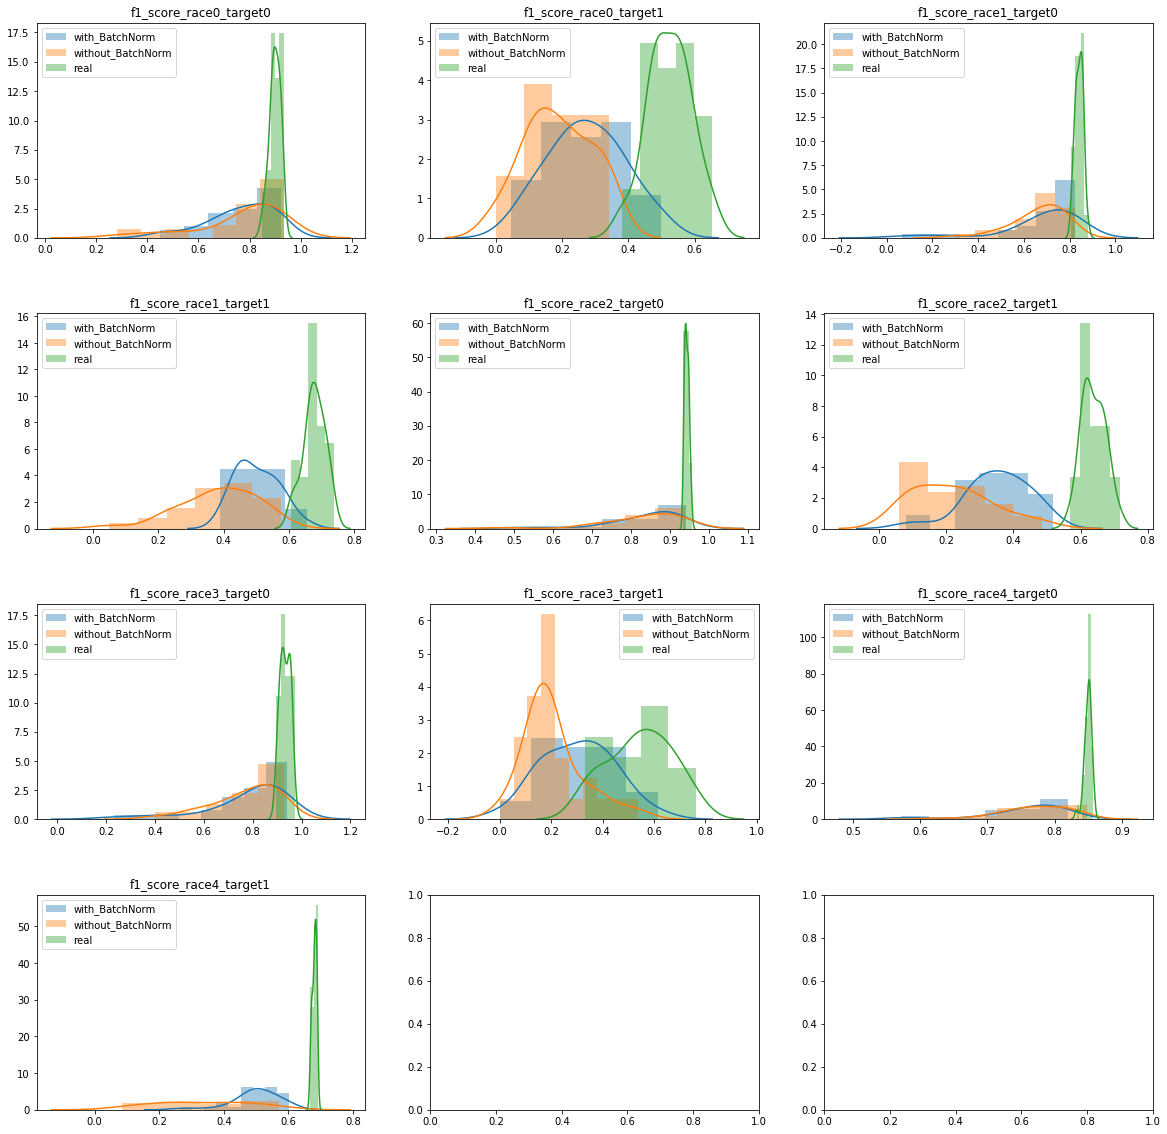

In [55]:
plot_data_utility_scores(
    target_col="output",
    data_path="data/",
    configs=configs,
    include_real=True,
    model=EvaluatorModelType.LogisticRegression, 
    metrics=[MetricType.F1], 
    scaler_type=ScalerType.ROBUST, 
    model_kwargs={"solver": "lbfgs", "class_weight": "balanced", "max_iter": 200},
    metric_kwargs={MetricType.F1: {"average": None}},
    subset="race",
)

In [13]:
config = "ef9980840b657869103bbfbbec1f7b02b2bc2dc6.pkl"  # vae_experiment2 - same configuration as [1]
eval_input = {'target_col': 'default', 'data_path': 'data/', 'config_file': config}
evaluator = MachineLearningEvaluator(**eval_input)
experiment_data = evaluator.get_experiment_data()
scores = evaluator.data_utility_scores(
    EvaluatorModelType.LogisticRegression, 
    [MetricType.F1], 
    ScalerType.ROBUST, 
    model_kwargs={"solver": "lbfgs", "class_weight": "balanced", "max_iter": 100},
    metric_kwargs={MetricType.F1: {"average": None}},
    subset="SEX",
    include_train=False,
)  
display(scores)

,fake_test_f1_score_SEX0_target0,real_test_f1_score_SEX0_target0,fake_test_f1_score_SEX0_target1,real_test_f1_score_SEX0_target1,fake_test_f1_score_SEX1_target0,real_test_f1_score_SEX1_target0,fake_test_f1_score_SEX1_target1,real_test_f1_score_SEX1_target1
0,0.575505,0.838746,0.260138,0.54429,0.689343,0.863023,0.224661,0.512626


In [95]:
existing_configs = MachineLearningEvaluator.existing_configs("data/", test_config=test_config)

In [97]:
for k, v in existing_configs.items():
    eval_input = {'target_col': 'output', 'data_path': 'data/', 'config_file': k}
    evaluator = MachineLearningEvaluator(**eval_input)
    experiment_data = evaluator.get_experiment_data()
    scores = evaluator.data_utility_scores(
    EvaluatorModelType.LogisticRegression, 
    [MetricType.F1], 
    ScalerType.ROBUST, 
    model_kwargs={"solver": "lbfgs", "class_weight": "balanced", "max_iter": 200},
    metric_kwargs={MetricType.F1: {"average": "binary"}},
    subset="race",
    include_train=False,
    )  
    display(scores)
    

Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.166667,0.647059,0.406130,0.699552,0.130952,0.614841,0.190476,0.434783,0.351717,0.683253
1,0.196721,0.470588,0.358333,0.649789,0.199052,0.643357,0.210526,0.642857,0.305385,0.673767
2,0.338983,0.512821,0.539568,0.675105,0.398876,0.626263,0.238095,0.571429,0.552341,0.688839


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.133333,0.540541,0.575758,0.654867,0.227273,0.624204,0.347826,0.551724,0.464607,0.676500
1,0.111111,0.380952,0.389189,0.660870,0.315789,0.589147,0.384615,0.636364,0.264224,0.683621
2,0.250000,0.562500,0.476510,0.721739,0.251029,0.717770,0.142857,0.352941,0.407621,0.673566


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.208333,0.476190,0.049383,0.676617,0.088773,0.621160,0.101695,0.500000,0.107980,0.672260
1,0.300000,0.538462,0.530120,0.679245,0.246154,0.626335,0.352941,0.352941,0.454545,0.680880
2,0.191489,0.585366,0.260163,0.663830,0.102079,0.651613,0.179104,0.740741,0.182567,0.688757


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.060606,0.651163,0.357724,0.680851,0.193548,0.600000,0.190476,0.642857,0.223988,0.681059
1,0.222222,0.466667,0.479452,0.632558,0.484277,0.666667,0.538462,0.518519,0.571266,0.670089
2,0.090909,0.451613,0.215909,0.694915,0.129032,0.656827,0.000000,0.500000,0.263468,0.687607


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.153846,0.473684,0.258333,0.660194,0.059801,0.593985,0.137931,0.571429,0.085118,0.690652
1,0.173913,0.555556,0.364532,0.674699,0.196491,0.618557,0.105263,0.421053,0.421711,0.682927
2,0.135593,0.545455,0.333333,0.706897,0.101266,0.694444,0.161290,0.761905,0.174894,0.671870


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.321429,0.500000,0.412371,0.663968,0.390892,0.615917,0.162162,0.571429,0.507967,0.678837
1,0.125000,0.555556,0.354680,0.685259,0.126482,0.651852,0.166667,0.516129,0.259525,0.678452
2,0.125000,0.466667,0.436548,0.709677,0.211982,0.666667,0.083333,0.636364,0.239572,0.680732


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.100000,0.600000,0.245399,0.694836,0.090090,0.680702,0.057143,0.666667,0.125677,0.686426
1,0.340426,0.564103,0.510204,0.721311,0.341709,0.611842,0.313725,0.551724,0.528894,0.666775
2,0.238095,0.400000,0.375000,0.607930,0.062016,0.615385,0.166667,0.400000,0.426167,0.681297


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.311688,0.514286,0.409449,0.615385,0.126667,0.640264,0.192308,0.333333,0.125080,0.687909
1,0.333333,0.555556,0.511111,0.728814,0.282723,0.611940,0.187500,0.538462,0.456545,0.684794
2,0.058824,0.500000,0.267559,0.711538,0.164534,0.657439,0.200000,0.714286,0.202121,0.669680


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.25641,0.600000,0.335079,0.704453,0.308861,0.688525,0.232558,0.50,0.384381,0.683116
1,0.12000,0.487805,0.493151,0.678261,0.270742,0.568345,0.148148,0.72,0.456318,0.678560
2,0.00000,0.473684,0.408304,0.653266,0.236301,0.664032,0.242424,0.40,0.285062,0.688044


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.341463,0.606061,0.484848,0.614634,0.464396,0.607407,0.454545,0.333333,0.566609,0.671748
1,0.000000,0.562500,0.206897,0.675799,0.061162,0.671141,0.140351,0.647059,0.278043,0.685560
2,0.242424,0.500000,0.466165,0.737255,0.291105,0.678322,0.153846,0.625000,0.374081,0.687448


In [93]:
for k, v in existing_configs.items():
    eval_input = {'target_col': 'output', 'data_path': 'data/', 'config_file': k}
    evaluator = MachineLearningEvaluator(**eval_input)
    experiment_data = evaluator.get_experiment_data()
    scores = evaluator.data_utility_scores(
    EvaluatorModelType.LogisticRegression, 
    [MetricType.F1], 
    ScalerType.ROBUST, 
    model_kwargs={"solver": "lbfgs", "class_weight": "balanced", "max_iter": 200},
    metric_kwargs={MetricType.F1: {"average": "binary"}},
    subset="race",
    include_train=False,
    )  
    display(scores)
    

Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.216216,0.647059,0.473430,0.699552,0.407407,0.614841,0.428571,0.434783,0.477797,0.683253
1,0.222222,0.470588,0.579926,0.649789,0.410000,0.643357,0.186047,0.642857,0.537381,0.673767
2,0.280000,0.512821,0.475472,0.675105,0.357853,0.626263,0.322581,0.571429,0.520307,0.688839


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.375000,0.540541,0.655319,0.654867,0.470255,0.624204,0.37500,0.551724,0.593390,0.676500
1,0.387097,0.380952,0.441767,0.660870,0.343891,0.589147,0.40000,0.636364,0.489199,0.683621
2,0.500000,0.562500,0.527919,0.721739,0.439834,0.717770,0.30303,0.352941,0.537233,0.673566


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.105263,0.476190,0.461538,0.676617,0.079365,0.621160,0.434783,0.500000,0.528934,0.672260
1,0.186047,0.538462,0.506849,0.679245,0.438596,0.626335,0.114286,0.352941,0.478716,0.680880
2,0.333333,0.585366,0.556962,0.663830,0.408696,0.651613,0.514286,0.740741,0.544047,0.688757


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.345679,0.651163,0.512111,0.680851,0.297959,0.600000,0.324324,0.642857,0.492291,0.681059
1,0.313725,0.466667,0.469841,0.632558,0.303653,0.666667,0.271186,0.518519,0.548675,0.670089
2,0.140845,0.451613,0.404762,0.694915,0.148492,0.656827,0.000000,0.500000,0.265368,0.687607


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.388889,0.473684,0.517073,0.660194,0.381271,0.593985,0.307692,0.571429,0.469208,0.690652
1,0.156863,0.555556,0.464286,0.674699,0.355212,0.618557,0.272727,0.421053,0.478414,0.682927
2,0.352941,0.545455,0.592920,0.706897,0.487437,0.694444,0.500000,0.761905,0.575839,0.671870


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.121212,0.500000,0.446512,0.663968,0.273381,0.615917,0.142857,0.571429,0.342251,0.678837
1,0.200000,0.555556,0.414097,0.685259,0.293651,0.651852,0.380952,0.516129,0.487642,0.678452
2,0.285714,0.466667,0.446541,0.709677,0.260054,0.666667,0.158416,0.636364,0.412178,0.680732


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.298507,0.600000,0.439898,0.694836,0.302083,0.680702,0.183908,0.666667,0.537206,0.686426
1,0.105263,0.564103,0.525862,0.721311,0.343066,0.611842,0.307692,0.551724,0.479452,0.666775
2,0.470588,0.400000,0.450549,0.607930,0.347305,0.615385,0.476190,0.400000,0.495032,0.681297


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.253165,0.514286,0.389892,0.615385,0.266940,0.640264,0.126984,0.333333,0.410775,0.687909
1,0.258065,0.555556,0.555556,0.728814,0.265957,0.611940,0.200000,0.538462,0.460846,0.684794
2,0.457143,0.500000,0.580087,0.711538,0.517110,0.657439,0.615385,0.714286,0.600413,0.669680


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.222222,0.600000,0.435088,0.704453,0.374468,0.688525,0.208333,0.50,0.440580,0.683116
1,0.045455,0.487805,0.578431,0.678261,0.407895,0.568345,0.421053,0.72,0.502298,0.678560
2,0.244898,0.473684,0.478964,0.653266,0.364146,0.664032,0.133333,0.40,0.508097,0.688044


Predicting Validation Scores


,fake_test_f1_score_race0,real_test_f1_score_race0,fake_test_f1_score_race1,real_test_f1_score_race1,fake_test_f1_score_race2,real_test_f1_score_race2,fake_test_f1_score_race3,real_test_f1_score_race3,fake_test_f1_score_race4,real_test_f1_score_race4
0,0.388889,0.606061,0.539535,0.614634,0.475294,0.607407,0.357143,0.333333,0.600255,0.671748
1,0.227273,0.562500,0.533937,0.675799,0.289593,0.671141,0.400000,0.647059,0.540272,0.685560
2,0.321429,0.500000,0.608997,0.737255,0.465517,0.678322,0.240000,0.625000,0.589219,0.687448
